# LSTM model

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
if len(tf.config.list_physical_devices('GPU')):
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Loading data

In [3]:
dataset = pd.read_csv("train_data_percentage", index_col=0)
dataset = dataset.dropna()
dataset = (dataset[(dataset.lang=="en")]).reset_index(drop=True).sort_index()
dataset = dataset.reset_index(drop=True).sort_index()

In [4]:
# Create categories from priceChanges
stepKey = "1stepChange"
threshold = 0.005
dataset.insert(loc=9,column="priceChangeClass", value=1)
dataset.at[dataset[dataset[stepKey] <= (1-threshold)].index, "priceChangeClass"] = 0
dataset.at[dataset[dataset[stepKey] >= (1+threshold)].index, "priceChangeClass"] = 2

In [5]:
smallest_amount_data = min(dataset.priceChangeClass.value_counts())

indexes = []
for unique_class in set(dataset.priceChangeClass):
        temp_indexes = dataset.loc[dataset.priceChangeClass==unique_class].sample(smallest_amount_data).index
        #print(list(temp_indexes))
        indexes += list(temp_indexes)

In [6]:
balanced_dataset = dataset.loc[indexes].sample(frac=1).reset_index(drop=True)

In [7]:
#TODO: remove 
#balanced_dataset = balanced_dataset.sample(n=10000).reset_index(drop=True).sort_index()

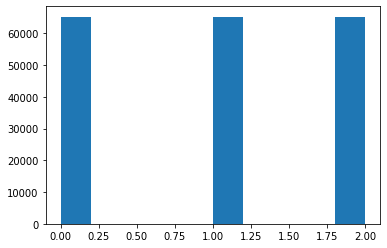

In [8]:
plt.hist(balanced_dataset.priceChangeClass)
plt.show()

In [9]:
seed = 12345

val_percent = 0.1
test_percent = 0.2

validation_data = (balanced_dataset.sample(frac=val_percent, random_state=seed)).reset_index(drop=True)
test_data = (balanced_dataset.sample(frac=test_percent, random_state=seed)).reset_index(drop=True)
train_data = (balanced_dataset.iloc[balanced_dataset.index.difference(test_data.index).difference(validation_data.index)]).reset_index(drop=True)

In [10]:
x_train = np.array(train_data.summary)
y_train = np.array(train_data.priceChangeClass).astype(np.int8)

val_x = np.array(validation_data.summary)
val_y = np.array(validation_data.priceChangeClass)

test_x = np.array(test_data.summary)
test_y = np.array(test_data.priceChangeClass).astype(np.int8)

In [13]:
train_data.iloc[0].summary

'New Zealand has banned a racist manifesto written by the suspected terrorist of two mosque shootings in Christchurch that killed 50 people.'

## LSTM model

In [14]:
max_features = 100000  # Maximum vocab size.
max_len = 512 # Sequence length to pad the outputs to.
embedding_dims = 2

encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_features, output_sequence_length=max_len)

encoder.adapt(test_data.summary.to_numpy())

In [15]:
vocab = np.array(encoder.get_vocabulary())
vocab.shape

(78417,)

In [16]:
train_data

,datetime,headline,summary,related,lang,source,1stepChange,2stepChange,3stepChange,priceChangeClass,6stepChange
0,2019-03-23 12:50:59-05:00,New Zealand bans terror suspect's racist manif...,New Zealand has banned a racist manifesto writ...,CIA,en,USA Today,1.015456,1.017002,1.020093,2,1.038640
1,2020-01-09 07:30:00-05:00,Alliance Data Schedules Fourth-Quarter and Ful...,"COLUMBUS, Ohio, Jan. 9, 2020 /PRNewswire/ -- A...",ADS,en,PR Newswire,1.010973,1.001968,1.001332,2,1.008335
2,2019-07-11 09:10:09-05:00,Why the Earnings Surprise Streak Could Continu...,ConocoPhillips (COP) has an impressive earning...,COP,en,Zacks Investment Research,0.991861,0.992837,0.991452,0,0.994872
3,2020-02-13 04:04:37-05:00,Airbus crushes Boeing with record jet deliveries,Boeing’s European rival Airbus wants to break ...,AIR,en,Russia Today,1.013072,1.017354,1.017805,2,1.014311
4,2019-06-08 12:00:02-05:00,Novo's oral semaglutide successful in two late...,Novo Nordisk (NVO) announces positive results ...,NVO,en,Seeking Alpha,1.003446,1.017434,1.021691,1,1.042368
...,...,...,...,...,...,...,...,...,...,...,...
156554,2019-11-01 07:23:00-05:00,Could GM potato trials lead to blight-resistan...,A genetically-modified (GM) potato engineered ...,GM,en,Eastern Daily Press,1.001346,1.004306,1.001615,1,1.015608
156555,2020-11-05 14:30:00-05:00,Insights on the Architectural Coatings Global ...,"DUBLIN, Nov. 5, 2020 /PRNewswire/ -- The ""Arch...",PPG,en,PR Newswire,1.000503,1.000324,0.993385,1,0.995614
156556,2019-01-11 07:01:30-05:00,Archer Daniels Midland makes a citrus play,No summary available.,FTK,en,Seeking Alpha,1.438889,1.438889,1.450000,2,1.466667
156557,2020-02-26 16:36:00-05:00,TJX Companies (TJX) Beats Q4 Earnings & Revenu...,TJX Companies' (TJX) fourth-quarter fiscal 202...,TJX,en,Zacks Investment Research,1.010564,1.001866,1.011988,2,1.004397


In [17]:
example = ['DUBLIN , May 26, 2020 /PRNewswire/ -- The "Commercial Vehicle & Off-highway Radar - Global Market Outlook (2018-2027)" report has been added to ResearchAndMarkets.com\'s offering. The Global Commercial Vehicle & Off-highway Radar market accounted for $94.37 million in 2018 and is expected to reach $723.61 million by 2027, growing at a CAGR of 25.4% during the forecast period. Some of the key factors propelling the market growth are increasing number of autonomous vehicles, rising demand for commercial vehicles, and need for measuring the velocity of vehicles with high accuracy. However, inability of the system to distinguish multiple targets is the restraining factor for the growth of the market. By vehicle type, commercial vehicle segment is expected to grow at a significant market share during the forecast period as it is becoming necessary to tackle speed, distance, and such parameters of the commercial vehicles. On the basis of geography, Asia Pacific is anticipated to hold considerable market share during the forecast period due to the increasing infrastructure projects initiated by governments in the region']
encoded_example = encoder(example).numpy()
encoded_example
for n in range(1):
  print("Original: ", example[n])
  print("")
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  DUBLIN , May 26, 2020 /PRNewswire/ -- The "Commercial Vehicle & Off-highway Radar - Global Market Outlook (2018-2027)" report has been added to ResearchAndMarkets.com's offering. The Global Commercial Vehicle & Off-highway Radar market accounted for $94.37 million in 2018 and is expected to reach $723.61 million by 2027, growing at a CAGR of 25.4% during the forecast period. Some of the key factors propelling the market growth are increasing number of autonomous vehicles, rising demand for commercial vehicles, and need for measuring the velocity of vehicles with high accuracy. However, inability of the system to distinguish multiple targets is the restraining factor for the growth of the market. By vehicle type, commercial vehicle segment is expected to grow at a significant market share during the forecast period as it is becoming necessary to tackle speed, distance, and such parameters of the commercial vehicles. On the basis of geography, Asia Pacific is anticipated to ho

In [27]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3)
])

"""
# 42% after 1 epoch
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
"""

"\n# 42% after 1 epoch\nmodel = tf.keras.Sequential([\n    encoder,\n    tf.keras.layers.Embedding(\n        input_dim=len(encoder.get_vocabulary()),\n        output_dim=64,\n        # Use masking to handle the variable sequence lengths\n        mask_zero=True),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),\n    tf.keras.layers.Dense(64, activation='relu'),\n    tf.keras.layers.Dense(3, activation='softmax')\n])\n"

In [28]:
print([layer.supports_masking for layer in model.layers])
sample_text = ('The Global Commercial Vehicle & Off-highway Radar market accounted for $94.37 million in 2018 and is expected to reach $723.61 million by 2027, growing at a CAGR of 25.4% during the forecast period. Some of the key factors propelling the market growth are increasing number of autonomous vehicles, rising demand for commercial vehicles, and need for measuring the velocity of vehicles with high accuracy. However, inability of the system to distinguish multiple targets is the restraining factor for the growth of the market.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[False, True, True, True, True, True]
[-0.01843481  0.01934541  0.01001768]


In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32))

In [ ]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(val_x, val_y),
    epochs=20)

Epoch 1/20
2954/4893 [=================>............] - ETA: 1:06 - loss: 1.0879 - accuracy: 0.3750

In [22]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

612/612 [==============================] - 5s 8ms/step - loss: 1.0864 - accuracy: 0.7840
Test Loss: 1.086441159248352
Test Accuracy: 0.7840061187744141


In [25]:
model.save(f"models/LSTM/{test_acc:.3f}_acc")

NameError: name 'history' is not defined

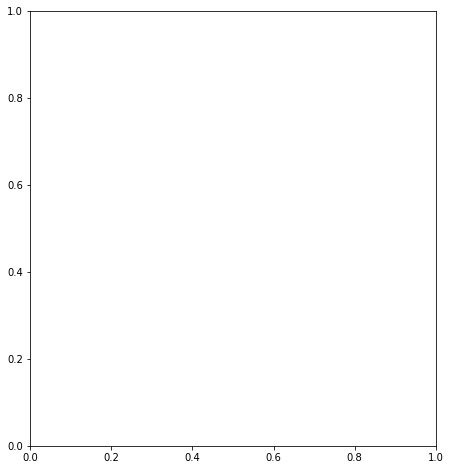

In [26]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)